In [10]:
# pip install librosa

In [9]:
# pip install opencv-python

In [5]:
# pip install numpy

In [6]:
# pip install pandas

In [9]:
# pip install -U scikit-learn

In [15]:
# pip install imbalanced-learn==0.8.0

In [12]:
# pip install -U matplotlib

In [14]:
# pip install -U seaborn

In [17]:
# pip install --user -U tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
#Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

gen_dir = "/Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/"

#gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"


In [1]:
# #Converting 1D ECG to 2D images (spectrograms) using STFT
#do not run this

# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import librosa
# import librosa.display
# from PIL import Image

# # Set the input and output directories
# gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"

# input_folder = os.path.join(gen_dir, "Data_ALL/ECG/ECG_csv_files_labeled_baseline6_pantompkins")
# output_folder = os.path.join(gen_dir, "Data_ALL/ECG_images_baseline6_STFT")

# # Create output directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Define the parameters for the STFT
# n_fft = 1024
# hop_length = 512

# # Loop through all the CSV files in the folder
# for filename in os.listdir(input_folder):
#     if filename.endswith(".csv"):
#         # Load the CSV file as a NumPy array
#         file_path = os.path.join(input_folder, filename)
#         ecg_signal = pd.read_csv(file_path, header=None).values.flatten()

#         # Compute the STFT
#         stft = librosa.stft(ecg_signal, n_fft=n_fft, hop_length=hop_length)
#         stft_mag_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

#         # Normalize the STFT to [0, 1] range
#         stft_norm = (stft_mag_db - np.min(stft_mag_db)) / np.ptp(stft_mag_db)

#         # Convert the STFT to a 8-bit grayscale image
#         stft_img = (stft_norm * 255).astype(np.uint8)

#         # Save the image as a PNG file
#         output_filename = os.path.splitext(filename)[0] + ".png"
#         output_path = os.path.join(output_folder, output_filename)
#         Image.fromarray(stft_img, mode="L").save(output_path)

#         print(f"Processed {filename} and saved {output_filename}")


In [11]:
#counting the length of the files EDA
#62, it matches the number of files in csv

gen_dir = "/Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/"

# Set the input and output directories
#gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"

import os
folder_path = os.path.join(gen_dir, "Data_ALL/ECG_images_baseline6_STFT")

# Count the number of files in the folder
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"There are {num_files} files in the {folder_path} folder.")


There are 81 files in the /Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/Data_ALL/ECG_images_baseline6_STFT folder.


In [12]:
#checking for the frequency if each class

import os

data_dir = os.path.join(gen_dir, "Data_ALL/ECG_images_baseline6_STFT")

class_counts = {0: 0, 1: 0}

for file_name in os.listdir(data_dir):
    if file_name.endswith(".png"):
        class_label = int(file_name.split("_")[-1].split(".")[0])
        class_counts[class_label] += 1

print(f"Class 0: {class_counts[0]} files")
print(f"Class 1: {class_counts[1]} files")

Class 0: 56 files
Class 1: 25 files


In [16]:
#extracting label from the filename

import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Set the data directory path
data_dir = os.path.join(gen_dir, "Data_ALL/ECG_images_baseline6_STFT")

X = []
y = []

# Go through all the files in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith(".png"):
        # Extract the label from the file name
        label = int(file_name.split("_")[-1][0])
        # Load the image file and preprocess it
        file_path = os.path.join(data_dir, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.array(img).reshape(-1)
        # Save the preprocessed image and label in a list
        X.append(img)
        y.append(label)

# Convert the data to numpy arrays
X = np.array(X)
y = np.array(y)

In [33]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random under-sampling to the data
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [34]:
# Print the shape and class counts of the resampled data
print("Resampled data shape:", X_resampled.shape)
unique, counts = np.unique(y_resampled, return_counts=True)
print("Class counts:", dict(zip(unique, counts)))

Resampled data shape: (50, 50176)
Class counts: {0: 25, 1: 25}


In [35]:
# Count the number of instances for each class in the resampled training data
class_counts = np.bincount(y_resampled)
print("Class distribution after Random Undersampling:", class_counts)

Class distribution after Random Undersampling: [25 25]


In [36]:
# Reshape the data into a 4D tensor
X_train = X_train.reshape((-1, 224, 224, 1))
X_test = X_test.reshape((-1, 224, 224, 1))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40, 224, 224, 1)
(40,)
(10, 224, 224, 1)
(10,)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Bidirectional, LSTM, Reshape, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

import tensorflow as tf
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

filter_size = 32
kernel_size = (3,3)
batch_size = 16
neurons = 256

# Define the model architecture
model = Sequential()
model.add(Conv2D(filter_size, kernel_size, activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filter_size*2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filter_size*4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_66 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_67 (Bat  (None, 109, 109, 64)     256       
 chNormalization)                                                
                                                     

1/1 [==============================] - 0s 155ms/step
[[5 0]
 [5 0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10

Specificity: 1.0
ROC AUC: 0.36


C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


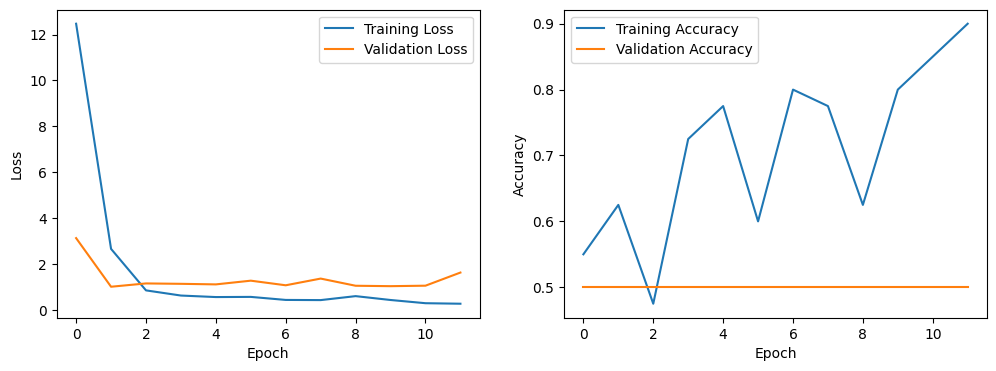

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Get the predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

# Print the classification report
print(classification_report(y_test, y_pred_classes))

# Calculate specificity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print('Specificity:', specificity)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC:', roc_auc)

import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create the figure and axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and validation accuracy
ax2.plot(train_acc, label='Training Accuracy')
ax2.plot(val_acc, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plot
plt.show()

cross-validation

In [38]:
#model for basic CNN

import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import random
# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

filter_size = 32
kernel_size = (3,3)
batch_size = 16
num_folds = 10
n_epochs = 30
neurons = 256

# Define the CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(filter_size, kernel_size, activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filter_size*2, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filter_size*4, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

#K-fold cross-validation lists
score_list = []
precision_list = []
recall_list = []
f1_score_list = []
confusion_matrix_list = []
specificity_list = []
ROC_AUC_list = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    #splitting the data into train and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
    
    #defining the early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    #early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    
    #training the model for this fold
    model = create_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, batch_size=batch_size, 
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop], verbose=1)
    
    #predicting the classes for the validation set for this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    #calculating precision, recall, specificity, F1 score, AUC, and confusion matrix for this fold
    precision_list.append(precision_score(y_val_fold, y_pred_classes))
    recall_list.append(recall_score(y_val_fold, y_pred_classes))
    f1_score_list.append(f1_score(y_val_fold, y_pred_classes))
    #tp, fp, fn, tn = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)
    ROC_AUC_list.append(roc_auc_score(y_val_fold, y_pred))
    confusion_matrix_list.append(confusion_matrix(y_val_fold, y_pred_classes))

    #evaluating the model on the test set for this fold
    #_, test_acc = model.evaluate(X_test, y_test)
    _, test_acc = model.evaluate(X_val_fold, y_val_fold)

    score_list.append(test_acc)
    
    #printing the metrics and confusion matrix for this fold
    print(f'Fold {fold + 1}: Accuracy = {test_acc:.4f}, \
      Precision = {precision_list[-1]:.4f}, \
      Recall = {recall_list[-1]:.4f}, \
      Specificity = {specificity_list[-1]:.4f}, \
      AUC = {ROC_AUC_list[-1]:.4f}, \
      F1 Score = {f1_score_list[-1]:.4f}')
    print(f'Confusion matrix:\n{confusion_matrix_list[-1]}')
    
#Print the average scores for all folds

print(f'Average Accuracy: {np.mean(score_list):.4f} +/- {np.std(score_list):.4f}')
print(f'Average Precision: {np.mean(precision_list):.4f} +/- {np.std(precision_list):.4f}')
print(f'Average Recall/Sensitivity: {np.mean(recall_list):.4f} +/- {np.std(recall_list):.4f}')
print(f'Average Specificity: {np.mean(specificity_list):.4f} +/- {np.std(specificity_list):.4f}')
print(f'Average F1-score: {np.mean(f1_score_list):.4f} +/- {np.std(f1_score_list):.4f}')
print(f'Average ROC_AUC score: {np.mean(ROC_AUC_list):.4f} +/- {np.std(ROC_AUC_list):.4f}')

#printing the overall confusion matrix

overall_cm = np.sum(confusion_matrix_list, axis=0)
print(f'Overall confusion matrix:\n{overall_cm}')

Epoch 1/30
3/3 [==============================] - 2s 495ms/step - loss: 7.5514 - accuracy: 0.6389 - val_loss: 3.9767 - val_accuracy: 0.2500
Epoch 2/30
3/3 [==============================] - 1s 391ms/step - loss: 3.2513 - accuracy: 0.4444 - val_loss: 1.4765 - val_accuracy: 0.7500
Epoch 3/30
3/3 [==============================] - 1s 387ms/step - loss: 0.6417 - accuracy: 0.5833 - val_loss: 0.9184 - val_accuracy: 0.7500
Epoch 4/30
3/3 [==============================] - 1s 383ms/step - loss: 0.5743 - accuracy: 0.6389 - val_loss: 0.7373 - val_accuracy: 0.7500
Epoch 5/30
3/3 [==============================] - 1s 388ms/step - loss: 0.5321 - accuracy: 0.6944 - val_loss: 0.6132 - val_accuracy: 0.7500
Epoch 6/30
3/3 [==============================] - 1s 387ms/step - loss: 0.5093 - accuracy: 0.7222 - val_loss: 0.5634 - val_accuracy: 0.7500
Epoch 7/30
3/3 [==============================] - 1s 384ms/step - loss: 0.6784 - accuracy: 0.5278 - val_loss: 0.5021 - val_accuracy: 0.7500
Epoch 8/30
3/3 [====

C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
3/3 [==============================] - 2s 493ms/step - loss: 21.9438 - accuracy: 0.4444 - val_loss: 9.4781 - val_accuracy: 0.2500
Epoch 2/30
3/3 [==============================] - 1s 401ms/step - loss: 2.3295 - accuracy: 0.5000 - val_loss: 0.4985 - val_accuracy: 0.7500
Epoch 3/30
3/3 [==============================] - 1s 402ms/step - loss: 0.6235 - accuracy: 0.5556 - val_loss: 0.4725 - val_accuracy: 0.7500
Epoch 4/30
3/3 [==============================] - 1s 365ms/step - loss: 0.6301 - accuracy: 0.5833 - val_loss: 0.4767 - val_accuracy: 0.7500
Epoch 5/30
3/3 [==============================] - 1s 368ms/step - loss: 0.5908 - accuracy: 0.5833 - val_loss: 0.4954 - val_accuracy: 0.7500
Epoch 6/30
3/3 [==============================] - 1s 371ms/step - loss: 0.5788 - accuracy: 0.6389 - val_loss: 0.5098 - val_accuracy: 0.7500
Epoch 6: early stopping
1/1 [==============================] - 0s 52ms/step - loss: 0.4725 - accuracy: 0.7500


C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2: Accuracy = 0.7500,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 1.0000,       F1 Score = 0.0000
Confusion matrix:
[[3 0]
 [1 0]]
Epoch 1/30
3/3 [==============================] - 2s 476ms/step - loss: 14.0860 - accuracy: 0.5278 - val_loss: 2.3970 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 383ms/step - loss: 4.5444 - accuracy: 0.5556 - val_loss: 0.7118 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 367ms/step - loss: 0.6791 - accuracy: 0.5000 - val_loss: 1.6907 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 388ms/step - loss: 0.8051 - accuracy: 0.5278 - val_loss: 0.6405 - val_accuracy: 0.7500
Epoch 5/30
3/3 [==============================] - 1s 365ms/step - loss: 0.6108 - accuracy: 0.7222 - val_loss: 0.9238 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 1s 385ms/step - loss: 0.6406 - accuracy: 0.6389 - val_loss: 0.6264 -

3/3 [==============================] - 1s 423ms/step - loss: 0.7630 - accuracy: 0.6111 - val_loss: 0.5901 - val_accuracy: 0.5000
Epoch 10/30
3/3 [==============================] - 1s 407ms/step - loss: 0.4191 - accuracy: 0.8611 - val_loss: 0.8957 - val_accuracy: 0.5000
Epoch 11/30
3/3 [==============================] - 1s 394ms/step - loss: 0.3286 - accuracy: 0.8611 - val_loss: 1.2560 - val_accuracy: 0.5000
Epoch 12/30
3/3 [==============================] - 1s 394ms/step - loss: 0.3184 - accuracy: 0.8889 - val_loss: 0.6019 - val_accuracy: 0.7500
Epoch 12: early stopping
1/1 [==============================] - 0s 54ms/step - loss: 0.5901 - accuracy: 0.5000
Fold 5: Accuracy = 0.5000,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 1.0000,       F1 Score = 0.0000
Confusion matrix:
[[2 0]
 [2 0]]


C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
3/3 [==============================] - 2s 481ms/step - loss: 12.6923 - accuracy: 0.5278 - val_loss: 27.2020 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 412ms/step - loss: 4.0655 - accuracy: 0.4444 - val_loss: 4.6120 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 407ms/step - loss: 0.6222 - accuracy: 0.4444 - val_loss: 3.5205 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 406ms/step - loss: 0.6202 - accuracy: 0.5556 - val_loss: 2.7354 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 1s 412ms/step - loss: 0.6171 - accuracy: 0.6111 - val_loss: 2.2057 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 1s 419ms/step - loss: 0.6156 - accuracy: 0.6111 - val_loss: 1.4515 - val_accuracy: 0.5000
Epoch 7/30
3/3 [==============================] - 1s 398ms/step - loss: 0.6035 - accuracy: 0.6389 - val_loss: 1.6591 - val_accuracy: 0.5000
Epoch 8/30
3/3 [==

C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6: Accuracy = 0.5000,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.5000,       F1 Score = 0.0000
Confusion matrix:
[[2 0]
 [2 0]]
Epoch 1/30
3/3 [==============================] - 2s 476ms/step - loss: 16.5257 - accuracy: 0.3889 - val_loss: 8.6240 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 412ms/step - loss: 2.4950 - accuracy: 0.5556 - val_loss: 3.6655 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 394ms/step - loss: 0.6451 - accuracy: 0.5000 - val_loss: 5.3674 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 409ms/step - loss: 1.4060 - accuracy: 0.4722 - val_loss: 1.6232 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 1s 409ms/step - loss: 0.6135 - accuracy: 0.6389 - val_loss: 1.4050 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 1s 383ms/step - loss: 0.5950 - accuracy: 0.6944 - val_loss: 1.5293 -

C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
3/3 [==============================] - 2s 476ms/step - loss: 22.8278 - accuracy: 0.5000 - val_loss: 47.7760 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 400ms/step - loss: 2.7189 - accuracy: 0.5556 - val_loss: 24.1166 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 407ms/step - loss: 0.5988 - accuracy: 0.5833 - val_loss: 19.9415 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 404ms/step - loss: 0.5947 - accuracy: 0.6111 - val_loss: 17.5280 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 1s 404ms/step - loss: 0.6914 - accuracy: 0.6111 - val_loss: 4.9039 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 1s 397ms/step - loss: 0.8705 - accuracy: 0.4444 - val_loss: 5.2762 - val_accuracy: 0.5000
Epoch 7/30
3/3 [==============================] - 1s 400ms/step - loss: 0.6680 - accuracy: 0.4722 - val_loss: 5.1589 - val_accuracy: 0.5000
Epoch 8/30
3/3 

C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 9: Accuracy = 0.5000,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.2500,       F1 Score = 0.0000
Confusion matrix:
[[2 0]
 [2 0]]
Epoch 1/30
3/3 [==============================] - 2s 503ms/step - loss: 6.8953 - accuracy: 0.5556 - val_loss: 210.1975 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 431ms/step - loss: 4.2282 - accuracy: 0.6667 - val_loss: 43.5992 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 424ms/step - loss: 0.7597 - accuracy: 0.5278 - val_loss: 22.9236 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 417ms/step - loss: 0.6069 - accuracy: 0.5556 - val_loss: 18.0559 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 1s 417ms/step - loss: 0.6410 - accuracy: 0.6111 - val_loss: 14.9988 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 1s 421ms/step - loss: 0.5921 - accuracy: 0.6111 - val_loss: 12.

C:\Anaconda3\envs\Xyrus\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

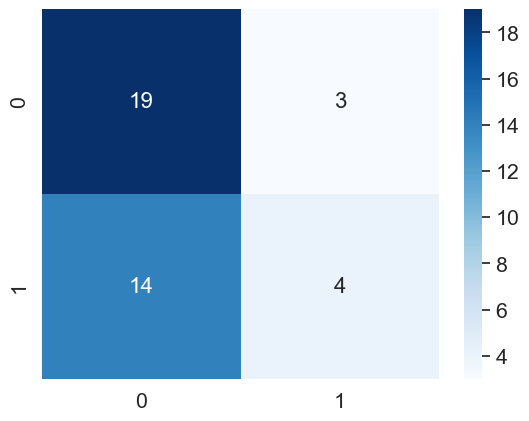

In [40]:
import seaborn as sns

sns.set(font_scale=1.4) # adjust font size as needed
sns.heatmap(overall_cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')